In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertConfig, BertForMaskedLM
from tqdm import tqdm
import time
from pytorch_msssim import ssim
import sys
from radam import RAdam
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Clone from https://github.com/Bjarten/early-stopping-pytorch
sys.path.append('/home/randycm/Documents/Research/Transformers/source/pytorchtools/') # Append path to EarlyStopping here
from pytorchtools import EarlyStopping

from watt.modules import *
from watt.utils import *

# Setup

## Load data

In [2]:
train_dataloader = torch.load('../data/train_loader.pth')
valid_dataloader = torch.load('../data/valid_loader.pth')

train_X, train_y = train_dataloader.dataset.tensors
valid_X, valid_y = valid_dataloader.dataset.tensors

## Initialize BERT config

In [3]:
config = BertConfig()

# Model Parameter
config.hidden_size = 8
config.num_hidden_layers = 4
config.num_attention_heads = 4
config.num_hidden_ffn = 4

config.vocab_size = 8
config.intermediate_size = config.hidden_size*config.num_hidden_ffn
config.initializer_range = .00005
config.max_length = 20
config.max_position_embeddings = config.max_length
config.position_embedding_type = 'sincos'
config.input_type = 'trace'
config.embedding_type = 'none'
config.type_vocab_size = 2
config.output_hidden_states = True
config.output_attentions = True
config.output_scores = True
# Toggle Pre-LN BERT
config.pre_ln = True # True, False

# Training Parameter
config.loss_fn = 'l2' # 'l2', 'ssiml1'
config.loss_pos = 'masked' # 'masked', 'all'
config.optim = 'radam' # 'adam', 'radam'
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20
config.batch_size = 64
config.parent_dir = './'
config.mask_procedure = "outside"

## Create the dataset

In [5]:
def reshape_data(data, seq_len):
    data = data[:data.shape[0] // seq_len * seq_len]
    data = data.reshape(data.shape[0] // seq_len, seq_len, -1)
    
    return data

train_X = reshape_data(train_X, config.max_length)
valid_X = reshape_data(valid_X, config.max_length)

In [6]:
train_data, valid_data = {}, {}

train_data['input'], valid_data['input'] = train_X.clone(), valid_X.clone()
train_data['label'], valid_data['label'] = train_X.clone(), valid_X.clone()

In [7]:
# Create the [mask] token
seed = 123
torch.manual_seed(seed)
mask_token = torch.randn(1, 1, train_data['input'].shape[-1])
mask_token = -1 + (2 * (mask_token - torch.min(mask_token)) / (torch.max(mask_token) - torch.min(mask_token)))

# Mask data
def mask_all(data, mask_proportion=.15):
    seq_len = data.shape[1]
    mask_label = torch.zeros(data.shape[0], seq_len)
    for i in range(data.shape[0]):
        muted_idx = torch.randperm(seq_len)[:int(np.floor(seq_len * mask_proportion))]
        for j in muted_idx:
            prob = torch.rand(1)
            if prob < 0.8:
                data[i, j, :] = mask_token
            elif prob >= 0.8 and prob < 0.9:
                switch_idx = torch.where(torch.arange(seq_len) != j)[0][torch.randint(high=seq_len-1, size=(1,))]
                data[i, j, :] = data[i, switch_idx, :].squeeze(-1)
            else:
                data[i, j, :] = data[i, j, :]

        mask_label[i, muted_idx] = 1
            
    return data, mask_label

for data in train_data, valid_data:
    data['input'], data['mask_label'] = mask_all(data['input'], mask_proportion=.15)

In [8]:
# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.data.items()}
    def __len__(self):
        return len(self.data['input'])
    
train_data = WirelineDataset(train_data)
valid_data = WirelineDataset(valid_data)

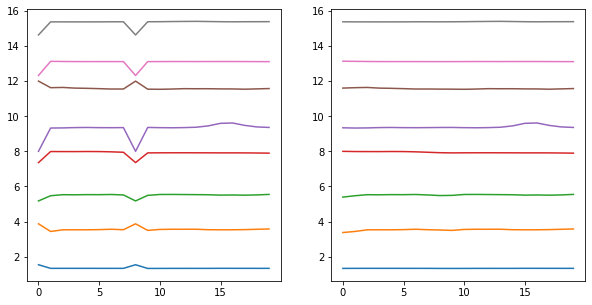

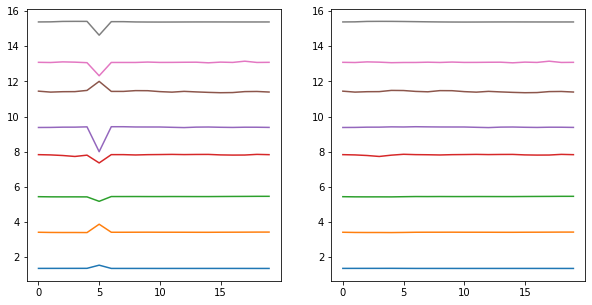

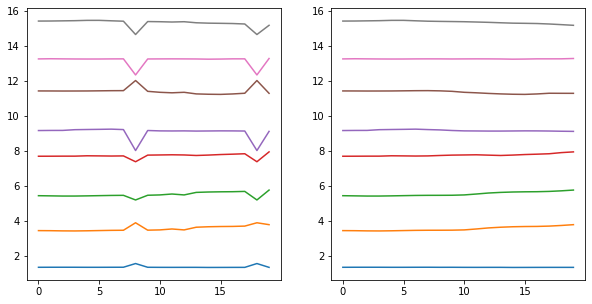

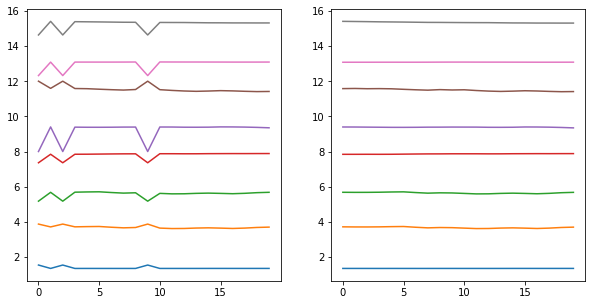

In [10]:
# Wrap in dataloader
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        ref = torch.arange(1, 2 * X['input'].shape[-1], 2).unsqueeze(0).repeat(X['input'].shape[1], 1)
        X['input'] = ref + X['input']
        X['label'] = ref + X['label']
        for j in range(4):
#             for k in range(X['input'].shape)
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(X['input'][j, :, :])
            ax[1].plot(X['label'][j, :, :])

## Initialize BERT model

In [11]:
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead

In [12]:
if config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

else:
    transformers.models.bert.modeling_bert.BertSelfOutput = BertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = BertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = BertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = BertOutput

In [13]:
model = BertForMaskedLM(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=8, out_features=8, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=8, out_features=8, bias=True)
              (key): Linear(in_features=8, out_features=8, bias=True)
              (value): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=8, out_features=8,

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


# Pre-training

In [15]:
# Optimizer
if config.optim == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=config.lr)
elif config.optim == 'radam':
    optim = RAdam(model.parameters(), lr=config.lr)

# Loss
if config.loss_fn == 'l2':
    loss_fn = nn.MSELoss(reduction='mean')
elif config.loss_fn in ['l1', 'ssiml1']:
    loss_fn = nn.L1Loss()

# Number of epochs
epochs = config.epoch

In [16]:
def run_training(epochs):
    total_time = time.time()
    avg_train_loss = []
    avg_valid_loss = []
    eps = []
    time_per_epoch = []
    # mask_proportion = [0, .05, .1, .15]
    checkpoint = os.path.join(config.parent_dir, str(os.getpid())+"checkpoint.pt")
    early_stopping = EarlyStopping(patience=config.patience, verbose=True, path=checkpoint)

    for epoch in range(epochs):
        epoch_time = time.time()
        model.train()
        # setup loop with TQDM and dataloader
        loop_train = tqdm(train_dataloader, leave=True)
        losses_train = 0
        for i, batch in enumerate(loop_train):
            # initialize calculated gradients (from prev step)
            optim.zero_grad()

            # pull all tensor batches required for training

            # Mask outside loop
            if config.mask_procedure == "outside":
                inputs_embeds = batch['input'].to(device)
                mask_label = batch['mask_label'].to(device)
                labels = batch['label'].to(device)
                
            # Mask inside loop
            elif config.mask_procedure == "inside":
                inputs_embeds, mask_label = mask_input(batch['input'], mask_proportion=config.mask_proportion)
                inputs_embeds = inputs_embeds.to(device)
                mask_label = mask_label.to(device)
                labels = batch['label'].to(device)

            # process

            outputs = model(inputs_embeds=inputs_embeds.float())

            if config.loss_pos == "masked":
                select_matrix = mask_label.unsqueeze(-1).expand(-1, -1, config.vocab_size)
            elif config.loss_pos == "all":
                select_matrix = 1

            if config.loss_fn == "l2":
                loss = loss_fn(outputs.logits * select_matrix, labels.float() * select_matrix)
            elif config.loss_fn == "ssiml1":
                masked_output = outputs.logits * select_matrix
                masked_output = masked_output.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                masked_label = labels * select_matrix
                masked_label = masked_label.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                loss1 = 1 - ssim(masked_output.unsqueeze(-1), masked_label.unsqueeze(-1))
                loss2 = loss_fn(masked_output, masked_label)
                loss = loss1 + loss2

            outputs.loss = loss
            outputs.loss.backward()

            # update parameters
            optim.step()            

            losses_train += loss.item()

            loop_train.set_description(f'Epoch {epoch}')
            loop_train.set_postfix(loss=loss.item())

            eps.append(optim.param_groups[0]["lr"])

        loop_valid = tqdm(valid_dataloader, leave=True)
        losses_valid = 0
        with torch.no_grad():
            for i, batch in enumerate(loop_valid):
                # pull all tensor batches required for training

                # Mask outside loop
                if config.mask_procedure == "outside":
                    inputs_embeds = batch['input'].to(device)
                    mask_label = batch['mask_label'].to(device)
                    labels = batch['label'].to(device)

                # Mask inside loop
                elif config.mask_procedure == "inside":
                    inputs_embeds, mask_label = mask_input(batch['input'], mask_proportion=config.mask_proportion)
                    inputs_embeds = inputs_embeds.to(device)
                    mask_label = mask_label.to(device)
                    labels = batch['label'].to(device)

                # process

                outputs = model(inputs_embeds=inputs_embeds.float())

                if config.loss_pos == "masked":
                    select_matrix = mask_label.unsqueeze(-1).expand(-1, -1, config.vocab_size)
                elif config.loss_pos == "all":
                    select_matrix = 1

                if config.loss_fn == "l2":
                    loss = loss_fn(outputs.logits * select_matrix, labels.float() * select_matrix)
                elif config.loss_fn == "ssiml1":
                    masked_output = outputs.logits * select_matrix
                    masked_output = masked_output.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                    masked_label = labels * select_matrix
                    masked_label = masked_label.unsqueeze(-1).repeat(1, 1, 1, 3).permute(0, 3, 1, 2)
                    loss1 = 1 - ssim(masked_output.unsqueeze(-1), masked_label.unsqueeze(-1))
                    loss2 = loss_fn(masked_output, masked_label)
                    loss = loss1 + loss2

                losses_valid += loss.item()

                loop_valid.set_description(f'Validation {epoch}')
                loop_valid.set_postfix(loss=loss.item())

        avg_train_loss.append(losses_train / len(train_dataloader))
        avg_valid_loss.append(losses_valid / len(valid_dataloader))
        print("Last learning rate: {}".format(eps[-1]))
        print("Epoch time: {:.2f} s".format(time.time() - epoch_time))
        time_per_epoch.append(time.time() - epoch_time)
        print("Total time elapsed: {:.2f} s".format(time.time() - total_time))
        print("---------------------------------------")
        
        ax1.cla()
        ax1.plot(np.arange(1, epoch+2), avg_train_loss,'b', label='Training Loss')
        ax1.plot(np.arange(1, epoch+2), avg_valid_loss, 'orange', label='Validation Loss')
        ax1.legend()
        ax1.set_title("Loss Curve")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Avg Loss")
        f1.canvas.draw()
        
        ax2.cla()
        ax2.plot(np.arange(1, len(train_dataloader)*(epoch+1)+1), eps,'b')
        ax2.set_title("Learning Rate Curve")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("lr")
        f2.canvas.draw()

        early_stopping(avg_valid_loss[-1], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(checkpoint))

    return model, avg_train_loss, avg_valid_loss, eps, time_per_epoch

<IPython.core.display.Javascript object>


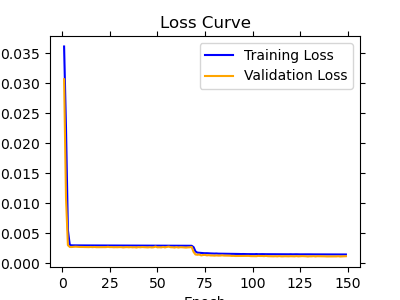

In [17]:
%matplotlib notebook

plt.ion()
f1, ax1 = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>


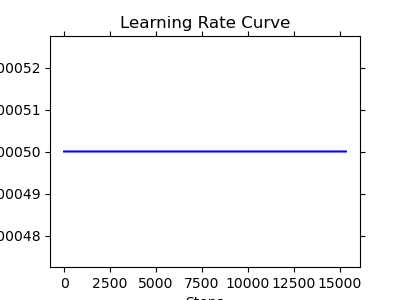

In [18]:
f2, ax2 = plt.subplots(figsize=(4, 3))

In [19]:
model, avg_train_loss, avg_valid_loss, eps, time_per_epoch = run_training(epochs)

%matplotlib inline
plt.ioff()

  0%|                                                   | 0/103 [00:00<?, ?it/s]/home/randycm/anaconda3/envs/transformers-2/lib/python3.8/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|███████████████| 34/34 [00:00<00:00, 160.82it/s, loss=0.0286]


Last learning rate: 0.0005
Epoch time: 3.71 s
Total time elapsed: 3.71 s
---------------------------------------
Validation loss decreased (inf --> 0.030711).  Saving model ...


Validation 1: 100%|███████████████| 34/34 [00:00<00:00, 162.24it/s, loss=0.0102]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 7.14 s
---------------------------------------
Validation loss decreased (0.030711 --> 0.010912).  Saving model ...


Validation 2: 100%|██████████████| 34/34 [00:00<00:00, 162.26it/s, loss=0.00292]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 10.60 s
---------------------------------------
Validation loss decreased (0.010912 --> 0.003027).  Saving model ...


Validation 3: 100%|███████████████| 34/34 [00:00<00:00, 164.69it/s, loss=0.0017]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 14.03 s
---------------------------------------
Validation loss decreased (0.003027 --> 0.002731).  Saving model ...


Validation 4: 100%|██████████████| 34/34 [00:00<00:00, 164.22it/s, loss=0.00263]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 17.49 s
---------------------------------------
Validation loss decreased (0.002731 --> 0.002725).  Saving model ...


Validation 5: 100%|██████████████| 34/34 [00:00<00:00, 163.19it/s, loss=0.00321]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 20.92 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 6: 100%|██████████████| 34/34 [00:00<00:00, 163.45it/s, loss=0.00487]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 24.39 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 7: 100%|██████████████| 34/34 [00:00<00:00, 161.78it/s, loss=0.00313]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 27.82 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 8: 100%|██████████████| 34/34 [00:00<00:00, 160.20it/s, loss=0.00307]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 31.21 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 9: 100%|██████████████| 34/34 [00:00<00:00, 165.16it/s, loss=0.00246]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 34.69 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 10: 100%|█████████████| 34/34 [00:00<00:00, 164.27it/s, loss=0.00232]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 38.16 s
---------------------------------------
Validation loss decreased (0.002725 --> 0.002720).  Saving model ...


Validation 11: 100%|█████████████| 34/34 [00:00<00:00, 164.13it/s, loss=0.00254]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 41.60 s
---------------------------------------
Validation loss decreased (0.002720 --> 0.002711).  Saving model ...


Validation 12: 100%|█████████████| 34/34 [00:00<00:00, 158.49it/s, loss=0.00201]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 45.06 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 13: 100%|██████████████| 34/34 [00:00<00:00, 161.58it/s, loss=0.0026]


Last learning rate: 0.0005
Epoch time: 3.25 s
Total time elapsed: 48.48 s
---------------------------------------
Validation loss decreased (0.002711 --> 0.002706).  Saving model ...


Validation 14: 100%|█████████████| 34/34 [00:00<00:00, 164.15it/s, loss=0.00215]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 51.92 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 15: 100%|██████████████| 34/34 [00:00<00:00, 162.37it/s, loss=0.0021]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 55.37 s
---------------------------------------
Validation loss decreased (0.002706 --> 0.002699).  Saving model ...


Validation 16: 100%|█████████████| 34/34 [00:00<00:00, 161.38it/s, loss=0.00294]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 58.85 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 17: 100%|█████████████| 34/34 [00:00<00:00, 163.56it/s, loss=0.00229]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 62.32 s
---------------------------------------
Validation loss decreased (0.002699 --> 0.002696).  Saving model ...


Validation 18: 100%|█████████████| 34/34 [00:00<00:00, 164.27it/s, loss=0.00232]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 65.75 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 19: 100%|█████████████| 34/34 [00:00<00:00, 162.38it/s, loss=0.00322]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 69.22 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 20: 100%|█████████████| 34/34 [00:00<00:00, 164.80it/s, loss=0.00234]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 72.68 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 21: 100%|███████████████| 34/34 [00:00<00:00, 164.63it/s, loss=0.002]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 76.13 s
---------------------------------------
Validation loss decreased (0.002696 --> 0.002694).  Saving model ...


Validation 22: 100%|█████████████| 34/34 [00:00<00:00, 162.41it/s, loss=0.00258]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 79.55 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 23: 100%|█████████████| 34/34 [00:00<00:00, 164.66it/s, loss=0.00603]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 82.98 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 24: 100%|██████████████| 34/34 [00:00<00:00, 150.90it/s, loss=0.0043]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 86.46 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 25: 100%|█████████████| 34/34 [00:00<00:00, 164.26it/s, loss=0.00288]


Last learning rate: 0.0005
Epoch time: 3.27 s
Total time elapsed: 89.84 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 26: 100%|█████████████| 34/34 [00:00<00:00, 161.98it/s, loss=0.00156]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 93.28 s
---------------------------------------
Validation loss decreased (0.002694 --> 0.002683).  Saving model ...


Validation 27: 100%|█████████████| 34/34 [00:00<00:00, 163.10it/s, loss=0.00281]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 96.74 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 28: 100%|█████████████| 34/34 [00:00<00:00, 163.25it/s, loss=0.00219]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 100.20 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 29: 100%|█████████████| 34/34 [00:00<00:00, 165.02it/s, loss=0.00333]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 103.66 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 30: 100%|█████████████| 34/34 [00:00<00:00, 166.66it/s, loss=0.00299]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 107.05 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 31: 100%|█████████████| 34/34 [00:00<00:00, 165.72it/s, loss=0.00199]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 110.52 s
---------------------------------------
Validation loss decreased (0.002683 --> 0.002654).  Saving model ...


Validation 32: 100%|█████████████| 34/34 [00:00<00:00, 162.63it/s, loss=0.00313]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 113.97 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 33: 100%|██████████████| 34/34 [00:00<00:00, 164.60it/s, loss=0.0029]


Last learning rate: 0.0005
Epoch time: 3.27 s
Total time elapsed: 117.34 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 34: 100%|█████████████| 34/34 [00:00<00:00, 162.57it/s, loss=0.00245]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 120.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 35: 100%|█████████████| 34/34 [00:00<00:00, 132.58it/s, loss=0.00466]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 124.21 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 36: 100%|█████████████| 34/34 [00:00<00:00, 164.19it/s, loss=0.00205]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 127.67 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 37: 100%|█████████████| 34/34 [00:00<00:00, 167.10it/s, loss=0.00159]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 131.11 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 38: 100%|██████████████| 34/34 [00:00<00:00, 162.49it/s, loss=0.0018]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 134.52 s
---------------------------------------
Validation loss decreased (0.002654 --> 0.002642).  Saving model ...


Validation 39: 100%|█████████████| 34/34 [00:00<00:00, 164.34it/s, loss=0.00353]


Last learning rate: 0.0005
Epoch time: 3.60 s
Total time elapsed: 138.24 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 40: 100%|█████████████| 34/34 [00:00<00:00, 147.30it/s, loss=0.00318]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 141.75 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 41: 100%|██████████████| 34/34 [00:00<00:00, 163.52it/s, loss=0.0025]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 145.20 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 42: 100%|█████████████| 34/34 [00:00<00:00, 163.52it/s, loss=0.00338]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 148.65 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 43: 100%|█████████████| 34/34 [00:00<00:00, 116.05it/s, loss=0.00261]


Last learning rate: 0.0005
Epoch time: 3.43 s
Total time elapsed: 152.19 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 44: 100%|█████████████| 34/34 [00:00<00:00, 160.01it/s, loss=0.00254]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 155.68 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 45: 100%|██████████████| 34/34 [00:00<00:00, 163.74it/s, loss=0.0024]


Last learning rate: 0.0005
Epoch time: 3.51 s
Total time elapsed: 159.29 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 46: 100%|█████████████| 34/34 [00:00<00:00, 163.60it/s, loss=0.00161]


Last learning rate: 0.0005
Epoch time: 3.68 s
Total time elapsed: 163.08 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 47: 100%|█████████████| 34/34 [00:00<00:00, 164.04it/s, loss=0.00304]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 166.56 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 48: 100%|█████████████| 34/34 [00:00<00:00, 164.57it/s, loss=0.00378]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 170.01 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 49: 100%|█████████████| 34/34 [00:00<00:00, 161.98it/s, loss=0.00228]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 173.51 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 50: 100%|█████████████| 34/34 [00:00<00:00, 165.23it/s, loss=0.00302]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 176.94 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 51: 100%|█████████████| 34/34 [00:00<00:00, 163.35it/s, loss=0.00146]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 180.31 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 52: 100%|█████████████| 34/34 [00:00<00:00, 164.68it/s, loss=0.00232]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 183.80 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 53: 100%|█████████████| 34/34 [00:00<00:00, 133.79it/s, loss=0.00175]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 187.31 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 54: 100%|█████████████| 34/34 [00:00<00:00, 161.89it/s, loss=0.00191]


Last learning rate: 0.0005
Epoch time: 3.58 s
Total time elapsed: 191.00 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 55: 100%|█████████████| 34/34 [00:00<00:00, 168.72it/s, loss=0.00418]


Last learning rate: 0.0005
Epoch time: 3.49 s
Total time elapsed: 194.60 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 56: 100%|█████████████| 34/34 [00:00<00:00, 160.75it/s, loss=0.00282]


Last learning rate: 0.0005
Epoch time: 3.49 s
Total time elapsed: 198.20 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 57: 100%|█████████████| 34/34 [00:00<00:00, 160.47it/s, loss=0.00272]


Last learning rate: 0.0005
Epoch time: 3.45 s
Total time elapsed: 201.77 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 58: 100%|█████████████| 34/34 [00:00<00:00, 159.66it/s, loss=0.00123]


Last learning rate: 0.0005
Epoch time: 3.63 s
Total time elapsed: 205.52 s
---------------------------------------
Validation loss decreased (0.002642 --> 0.002638).  Saving model ...


Validation 59: 100%|█████████████| 34/34 [00:00<00:00, 160.51it/s, loss=0.00195]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 209.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 60: 100%|█████████████| 34/34 [00:00<00:00, 160.60it/s, loss=0.00292]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 212.53 s
---------------------------------------
Validation loss decreased (0.002638 --> 0.002637).  Saving model ...


Validation 61: 100%|█████████████| 34/34 [00:00<00:00, 162.74it/s, loss=0.00381]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 215.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 62: 100%|█████████████| 34/34 [00:00<00:00, 145.95it/s, loss=0.00289]


Last learning rate: 0.0005
Epoch time: 3.41 s
Total time elapsed: 219.52 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 63: 100%|█████████████| 34/34 [00:00<00:00, 141.64it/s, loss=0.00173]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 222.98 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 64: 100%|█████████████| 34/34 [00:00<00:00, 156.32it/s, loss=0.00202]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 226.39 s
---------------------------------------
Validation loss decreased (0.002637 --> 0.002630).  Saving model ...


Validation 65: 100%|█████████████| 34/34 [00:00<00:00, 164.05it/s, loss=0.00208]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 229.84 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 66: 100%|█████████████| 34/34 [00:00<00:00, 163.23it/s, loss=0.00219]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 233.26 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 67: 100%|█████████████| 34/34 [00:00<00:00, 148.75it/s, loss=0.00371]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 236.73 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 68: 100%|██████████████| 34/34 [00:00<00:00, 144.12it/s, loss=0.0013]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 240.18 s
---------------------------------------
Validation loss decreased (0.002630 --> 0.001906).  Saving model ...


Validation 69: 100%|█████████████| 34/34 [00:00<00:00, 163.78it/s, loss=0.00165]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 243.61 s
---------------------------------------
Validation loss decreased (0.001906 --> 0.001476).  Saving model ...


Validation 70: 100%|█████████████| 34/34 [00:00<00:00, 164.44it/s, loss=0.00138]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 247.06 s
---------------------------------------
Validation loss decreased (0.001476 --> 0.001428).  Saving model ...


Validation 71: 100%|██████████████| 34/34 [00:00<00:00, 165.59it/s, loss=0.0011]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 250.50 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 72: 100%|█████████████| 34/34 [00:00<00:00, 155.20it/s, loss=0.00101]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 253.97 s
---------------------------------------
Validation loss decreased (0.001428 --> 0.001320).  Saving model ...


Validation 73: 100%|█████████████| 34/34 [00:00<00:00, 124.46it/s, loss=0.00174]


Last learning rate: 0.0005
Epoch time: 3.47 s
Total time elapsed: 257.57 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 74: 100%|████████████| 34/34 [00:00<00:00, 160.82it/s, loss=0.000737]


Last learning rate: 0.0005
Epoch time: 3.48 s
Total time elapsed: 261.16 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 75: 100%|█████████████| 34/34 [00:00<00:00, 161.64it/s, loss=0.00119]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 264.54 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 76: 100%|█████████████| 34/34 [00:00<00:00, 163.19it/s, loss=0.00149]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 268.02 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 77: 100%|█████████████| 34/34 [00:00<00:00, 161.71it/s, loss=0.00155]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 271.52 s
---------------------------------------
Validation loss decreased (0.001320 --> 0.001312).  Saving model ...


Validation 78: 100%|█████████████| 34/34 [00:00<00:00, 160.39it/s, loss=0.00127]


Last learning rate: 0.0005
Epoch time: 3.51 s
Total time elapsed: 275.14 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 79: 100%|█████████████| 34/34 [00:00<00:00, 163.64it/s, loss=0.00141]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 278.63 s
---------------------------------------
Validation loss decreased (0.001312 --> 0.001285).  Saving model ...


Validation 80: 100%|█████████████| 34/34 [00:00<00:00, 143.89it/s, loss=0.00197]


Last learning rate: 0.0005
Epoch time: 3.48 s
Total time elapsed: 282.22 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 81: 100%|█████████████| 34/34 [00:00<00:00, 147.39it/s, loss=0.00107]


Last learning rate: 0.0005
Epoch time: 3.54 s
Total time elapsed: 285.87 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 82: 100%|██████████████| 34/34 [00:00<00:00, 165.29it/s, loss=0.0012]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 289.33 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 83: 100%|█████████████| 34/34 [00:00<00:00, 162.27it/s, loss=0.00198]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 292.81 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 84: 100%|█████████████| 34/34 [00:00<00:00, 153.66it/s, loss=0.00104]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 296.26 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 85: 100%|█████████████| 34/34 [00:00<00:00, 155.43it/s, loss=0.00109]


Last learning rate: 0.0005
Epoch time: 3.41 s
Total time elapsed: 299.78 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 86: 100%|█████████████| 34/34 [00:00<00:00, 163.52it/s, loss=0.00168]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 303.24 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 87: 100%|████████████| 34/34 [00:00<00:00, 167.83it/s, loss=0.000967]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 306.68 s
---------------------------------------
Validation loss decreased (0.001285 --> 0.001276).  Saving model ...


Validation 88: 100%|████████████| 34/34 [00:00<00:00, 161.97it/s, loss=0.000789]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 310.13 s
---------------------------------------
Validation loss decreased (0.001276 --> 0.001242).  Saving model ...


Validation 89: 100%|█████████████| 34/34 [00:00<00:00, 164.27it/s, loss=0.00127]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 313.65 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 90: 100%|████████████| 34/34 [00:00<00:00, 163.86it/s, loss=0.000904]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 317.11 s
---------------------------------------
Validation loss decreased (0.001242 --> 0.001224).  Saving model ...


Validation 91: 100%|████████████| 34/34 [00:00<00:00, 162.17it/s, loss=0.000961]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 320.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 92: 100%|█████████████| 34/34 [00:00<00:00, 147.49it/s, loss=0.00135]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 324.07 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 93: 100%|█████████████| 34/34 [00:00<00:00, 164.88it/s, loss=0.00127]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 327.54 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 94: 100%|████████████| 34/34 [00:00<00:00, 166.54it/s, loss=0.000833]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 330.98 s
---------------------------------------
Validation loss decreased (0.001224 --> 0.001208).  Saving model ...


Validation 95: 100%|██████████████| 34/34 [00:00<00:00, 164.21it/s, loss=0.0014]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 334.43 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 96: 100%|█████████████| 34/34 [00:00<00:00, 162.55it/s, loss=0.00116]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 337.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 97: 100%|█████████████| 34/34 [00:00<00:00, 146.70it/s, loss=0.00121]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 341.37 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 98: 100%|█████████████| 34/34 [00:00<00:00, 163.22it/s, loss=0.00122]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 344.77 s
---------------------------------------
Validation loss decreased (0.001208 --> 0.001205).  Saving model ...


Validation 99: 100%|█████████████| 34/34 [00:00<00:00, 163.30it/s, loss=0.00132]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 348.19 s
---------------------------------------
Validation loss decreased (0.001205 --> 0.001198).  Saving model ...


Validation 100: 100%|████████████| 34/34 [00:00<00:00, 167.89it/s, loss=0.00114]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 351.64 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 101: 100%|███████████| 34/34 [00:00<00:00, 163.51it/s, loss=0.000886]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 355.13 s
---------------------------------------
Validation loss decreased (0.001198 --> 0.001193).  Saving model ...


Validation 102: 100%|███████████| 34/34 [00:00<00:00, 164.32it/s, loss=0.000923]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 358.60 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 103: 100%|████████████| 34/34 [00:00<00:00, 146.77it/s, loss=0.00112]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 362.13 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 104: 100%|████████████| 34/34 [00:00<00:00, 163.54it/s, loss=0.00138]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 365.56 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 105: 100%|████████████| 34/34 [00:00<00:00, 147.21it/s, loss=0.00131]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 369.00 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 106: 100%|████████████| 34/34 [00:00<00:00, 163.63it/s, loss=0.00193]


Last learning rate: 0.0005
Epoch time: 3.41 s
Total time elapsed: 372.52 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 107: 100%|████████████| 34/34 [00:00<00:00, 159.04it/s, loss=0.00106]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 376.00 s
---------------------------------------
Validation loss decreased (0.001193 --> 0.001193).  Saving model ...


Validation 108: 100%|████████████| 34/34 [00:00<00:00, 145.18it/s, loss=0.00155]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 379.51 s
---------------------------------------
Validation loss decreased (0.001193 --> 0.001185).  Saving model ...


Validation 109: 100%|███████████| 34/34 [00:00<00:00, 162.43it/s, loss=0.000994]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 383.00 s
---------------------------------------
Validation loss decreased (0.001185 --> 0.001176).  Saving model ...


Validation 110: 100%|███████████| 34/34 [00:00<00:00, 161.36it/s, loss=0.000826]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 386.48 s
---------------------------------------
Validation loss decreased (0.001176 --> 0.001170).  Saving model ...


Validation 111: 100%|████████████| 34/34 [00:00<00:00, 145.77it/s, loss=0.00122]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 389.98 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 112: 100%|████████████| 34/34 [00:00<00:00, 164.06it/s, loss=0.00061]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 393.41 s
---------------------------------------
Validation loss decreased (0.001170 --> 0.001165).  Saving model ...


Validation 113: 100%|█████████████| 34/34 [00:00<00:00, 149.18it/s, loss=0.0017]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 396.86 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 114: 100%|███████████| 34/34 [00:00<00:00, 161.98it/s, loss=0.000903]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 400.30 s
---------------------------------------
Validation loss decreased (0.001165 --> 0.001165).  Saving model ...


Validation 115: 100%|███████████| 34/34 [00:00<00:00, 162.90it/s, loss=0.000702]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 403.77 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 116: 100%|████████████| 34/34 [00:00<00:00, 158.76it/s, loss=0.00111]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 407.26 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 117: 100%|███████████| 34/34 [00:00<00:00, 145.92it/s, loss=0.000708]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 410.81 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 118: 100%|███████████| 34/34 [00:00<00:00, 165.80it/s, loss=0.000761]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 414.22 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 119: 100%|███████████| 34/34 [00:00<00:00, 164.77it/s, loss=0.000706]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 417.69 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 120: 100%|████████████| 34/34 [00:00<00:00, 146.68it/s, loss=0.00151]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 421.19 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 121: 100%|████████████| 34/34 [00:00<00:00, 133.28it/s, loss=0.00087]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 424.67 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 122: 100%|████████████| 34/34 [00:00<00:00, 165.38it/s, loss=0.00164]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 428.07 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 123: 100%|███████████| 34/34 [00:00<00:00, 129.02it/s, loss=0.000992]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 431.58 s
---------------------------------------
Validation loss decreased (0.001165 --> 0.001163).  Saving model ...


Validation 124: 100%|████████████| 34/34 [00:00<00:00, 158.63it/s, loss=0.00129]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 435.09 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 125: 100%|████████████| 34/34 [00:00<00:00, 143.90it/s, loss=0.00144]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 438.57 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 126: 100%|███████████| 34/34 [00:00<00:00, 161.19it/s, loss=0.000794]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 442.04 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 127: 100%|███████████| 34/34 [00:00<00:00, 148.02it/s, loss=0.000821]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 445.54 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 128: 100%|███████████| 34/34 [00:00<00:00, 152.26it/s, loss=0.000809]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 449.01 s
---------------------------------------
Validation loss decreased (0.001163 --> 0.001141).  Saving model ...


Validation 129: 100%|████████████| 34/34 [00:00<00:00, 163.57it/s, loss=0.00139]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 452.48 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 130: 100%|████████████| 34/34 [00:00<00:00, 159.82it/s, loss=0.00119]


Last learning rate: 0.0005
Epoch time: 3.70 s
Total time elapsed: 456.29 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 131: 100%|████████████| 34/34 [00:00<00:00, 162.19it/s, loss=0.00121]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 459.76 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 132: 100%|████████████| 34/34 [00:00<00:00, 161.75it/s, loss=0.00118]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 463.24 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 133: 100%|████████████| 34/34 [00:00<00:00, 162.59it/s, loss=0.00106]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 466.75 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 134: 100%|████████████| 34/34 [00:00<00:00, 164.32it/s, loss=0.00107]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 470.20 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 135: 100%|████████████| 34/34 [00:00<00:00, 163.88it/s, loss=0.00122]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 473.66 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 136: 100%|███████████| 34/34 [00:00<00:00, 160.72it/s, loss=0.000946]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 477.10 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 137: 100%|████████████| 34/34 [00:00<00:00, 161.95it/s, loss=0.00141]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 480.50 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 138: 100%|███████████| 34/34 [00:00<00:00, 164.35it/s, loss=0.000887]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 483.93 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 139: 100%|█████████████| 34/34 [00:00<00:00, 142.84it/s, loss=0.0013]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 487.42 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 140: 100%|████████████| 34/34 [00:00<00:00, 163.49it/s, loss=0.00108]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 490.88 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 141: 100%|████████████| 34/34 [00:00<00:00, 126.66it/s, loss=0.00105]


Last learning rate: 0.0005
Epoch time: 3.43 s
Total time elapsed: 494.42 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 142: 100%|████████████| 34/34 [00:00<00:00, 162.77it/s, loss=0.00128]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 497.92 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 143: 100%|████████████| 34/34 [00:00<00:00, 160.40it/s, loss=0.00161]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 501.40 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 144: 100%|████████████| 34/34 [00:00<00:00, 164.91it/s, loss=0.00139]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 504.91 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 145: 100%|████████████| 34/34 [00:00<00:00, 164.12it/s, loss=0.00074]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 508.38 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 146: 100%|███████████| 34/34 [00:00<00:00, 165.92it/s, loss=0.000904]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 511.81 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 147: 100%|█████████████| 34/34 [00:00<00:00, 161.46it/s, loss=0.0014]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 515.26 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 148: 100%|████████████| 34/34 [00:00<00:00, 163.19it/s, loss=0.00182]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 518.73 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


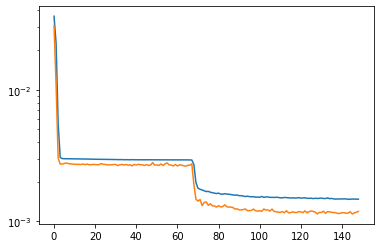

In [24]:
plt.semilogy(avg_train_loss)
plt.semilogy(avg_valid_loss)

## Plot result

/tmp/ipykernel_27995/1773832764.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_yticklabels(yticks)


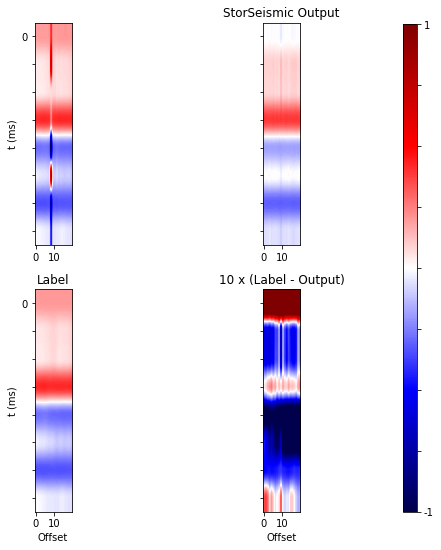

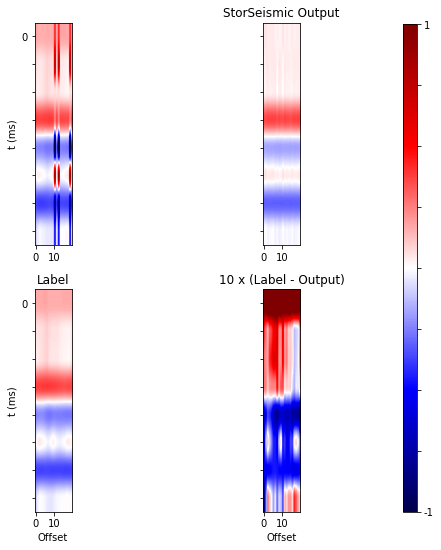

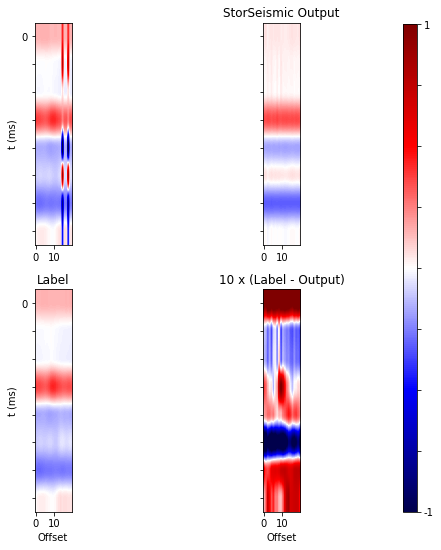

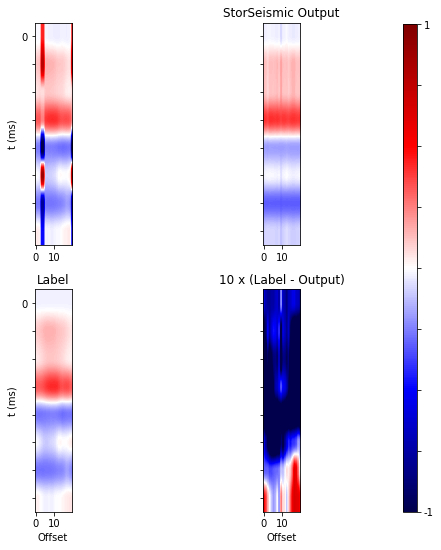

In [36]:
idx = torch.randint(high=len(valid_data), size=(4,))
inputs_embeds = valid_data.data['input'][idx]
labels = valid_data.data['label'][idx]
mask_label = valid_data.data['mask_label'][idx].unsqueeze(-1).expand(-1, -1, config.vocab_size)
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())
# i = 1

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    f, ax = plt.subplots(2, 2, figsize=(7.5, 9), sharey=True, sharex=False)
    ax[0, 0].imshow(X.detach().swapaxes(0, 1) - X.mean(dim=1), aspect=15, vmin=-1, vmax=1, cmap='seismic')
#     ax[0, 0].set_title("Input ({})".format("Field" if index < 0 else "Synthetic"))
    yticks = [0]+list(np.arange(0, 2*config.vocab_size, 2*50))
    ax[0, 0].set_yticklabels(yticks)
    ax[0, 0].set_ylabel("t (ms)")
#     output = torch.where(mask == 0, X.float(), y)
    output = y
    ax[0, 1].imshow(output.detach().swapaxes(0, 1) - output.mean(), aspect=15, vmin=-1, vmax=1, cmap='seismic')
    ax[0, 1].set_title("StorSeismic Output")
    ax[1, 0].imshow(z.detach().swapaxes(0, 1) - z.mean(), aspect=15, vmin=-1, vmax=1, cmap='seismic')
    ax[1, 0].set_title("Label")
    ax[1, 0].set_xlabel("Offset")
    ax[1, 0].set_ylabel("t (ms)")
    diff = 10 * (z - output)
    im4 = ax[1, 1].imshow(diff.detach().swapaxes(0, 1), aspect=15, vmin=-1, vmax=1, cmap='seismic')
    ax[1, 1].set_title("10 x (Label - Output)")
    ax[1, 1].set_xlabel("Offset")
    cbar_ax = f.add_axes([0.95, 0.125, 0.025, 0.7525])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

# Fine-tuning

## Create fine-tuning dataset

In [68]:
train_y = reshape_data(train_y, config.max_length)
valid_y = reshape_data(valid_y, config.max_length)

In [69]:
train_data2, valid_data2 = {}, {}

train_data2['input'], valid_data2['input'] = train_X.clone(), valid_X.clone()
train_data2['label'], valid_data2['label'] = train_y.clone(), valid_y.clone()

In [70]:
train_data2 = WirelineDataset(train_data2)
valid_data2 = WirelineDataset(valid_data2)

In [71]:
train_dataloader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=True)
valid_dataloader2 = DataLoader(valid_data2, batch_size=batch_size, shuffle=True)

## Initialize fine-tuning model

In [72]:
class DTSPredHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.predictions = nn.Linear(config.hidden_size, 1)
        self.predictions.decoder = Identity()
        
    def forward(self, sequence_output):
        output = self.predictions(sequence_output)

        return output

In [73]:
# Replace the prediciton head of the pre-trained model
model.cls = DTSPredHead(config)
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=8, out_features=8, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((8,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=8, out_features=8, bias=True)
              (key): Linear(in_features=8, out_features=8, bias=True)
              (value): Linear(in_features=8, out_features=8, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=8, out_features=8,

In [74]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Train

In [75]:
epochs = config.epoch

def run_training2(epochs):
    total_time = time.time()
    avg_train_loss = []
    avg_valid_loss = []
    eps = []
    time_per_epoch = []
    # mask_proportion = [0, .05, .1, .15]
    checkpoint = os.path.join(config.parent_dir, str(os.getpid())+"checkpoint.pt")
    early_stopping = EarlyStopping(patience=config.patience, verbose=True, path=checkpoint)

    for epoch in range(epochs):
        epoch_time = time.time()
        model.train()
        # setup loop with TQDM and dataloader
        loop_train = tqdm(train_dataloader2, leave=True)
        losses_train = 0
        for i, batch in enumerate(loop_train):
            # initialize calculated gradients (from prev step)
            optim.zero_grad()

            # pull all tensor batches required for training

            # Mask outside loop
            inputs_embeds = batch['input'].float().to(device)
            labels = batch['label'].to(device)

            # process

            outputs = model(inputs_embeds=inputs_embeds)
            
            loss = loss_fn(outputs.logits, labels)
            
            outputs.loss = loss
            outputs.loss.backward()

            # update parameters
            optim.step()
            
            losses_train += loss.item()

            loop_train.set_description(f'Epoch {epoch}')
            loop_train.set_postfix(loss=loss.item())

            eps.append(optim.param_groups[0]["lr"])

#         model.eval()
        loop_valid = tqdm(valid_dataloader2, leave=True)
        losses_valid = 0
        with torch.no_grad():
            for i, batch in enumerate(loop_valid):
                # pull all tensor batches required for training

                # Mask outside loop
                inputs_embeds = batch['input'].float().to(device)
                labels = batch['label'].to(device)

                # process

                outputs = model(inputs_embeds=inputs_embeds)
                
                loss = loss_fn(outputs.logits, labels)

                losses_valid += loss.item()

                loop_valid.set_description(f'Validation {epoch}')
                loop_valid.set_postfix(loss=loss.item())

        avg_train_loss.append(losses_train / len(train_dataloader))
        avg_valid_loss.append(losses_valid / len(valid_dataloader))
        print("Last learning rate: {}".format(eps[-1]))
        print("Epoch time: {:.2f} s".format(time.time() - epoch_time))
        time_per_epoch.append(time.time() - epoch_time)
        print("Total time elapsed: {:.2f} s".format(time.time() - total_time))
        print("---------------------------------------")

        ax1.cla()
        ax1.plot(np.arange(1, epoch+2), avg_train_loss,'b', label='Training Loss')
        ax1.plot(np.arange(1, epoch+2), avg_valid_loss, 'orange', label='Validation Loss')
        ax1.legend()
        ax1.set_title("Loss Curve")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Avg Loss")
        f1.canvas.draw()
        
        ax2.cla()
        ax2.plot(np.arange(1, len(train_dataloader)*(epoch+1)+1), eps,'b')
        ax2.set_title("Learning Rate Curve")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("lr")
        f2.canvas.draw()
        
        early_stopping(avg_valid_loss[-1], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    model.load_state_dict(torch.load(checkpoint))
    
    return model, avg_train_loss, avg_valid_loss, eps, time_per_epoch

<IPython.core.display.Javascript object>


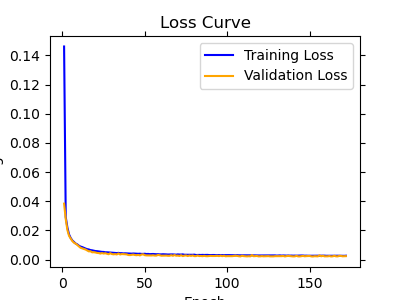

In [76]:
%matplotlib notebook

plt.ion()
f1, ax1 = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>


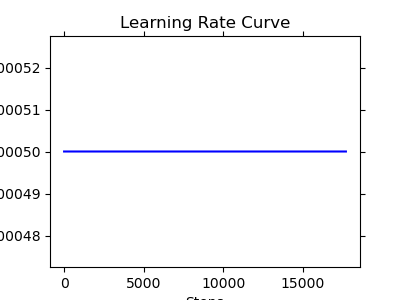

In [77]:
f2, ax2 = plt.subplots(figsize=(4, 3))

In [78]:
model2, avg_train_loss2, avg_valid_loss, eps2, time_per_epoch2 = run_training2(epochs)

%matplotlib inline
plt.ioff()

Validation 0: 100%|███████████████| 34/34 [00:00<00:00, 169.63it/s, loss=0.0618]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 3.39 s
---------------------------------------
Validation loss decreased (inf --> 0.038413).  Saving model ...


Validation 1: 100%|███████████████| 34/34 [00:00<00:00, 171.40it/s, loss=0.0357]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 6.82 s
---------------------------------------
Validation loss decreased (0.038413 --> 0.027787).  Saving model ...


Validation 2: 100%|███████████████| 34/34 [00:00<00:00, 173.93it/s, loss=0.0286]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 10.24 s
---------------------------------------
Validation loss decreased (0.027787 --> 0.020376).  Saving model ...


Validation 3: 100%|██████████████| 34/34 [00:00<00:00, 171.74it/s, loss=0.00655]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 13.71 s
---------------------------------------
Validation loss decreased (0.020376 --> 0.016350).  Saving model ...


Validation 4: 100%|███████████████| 34/34 [00:00<00:00, 170.46it/s, loss=0.0152]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 17.15 s
---------------------------------------
Validation loss decreased (0.016350 --> 0.014464).  Saving model ...


Validation 5: 100%|███████████████| 34/34 [00:00<00:00, 173.16it/s, loss=0.0056]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 20.60 s
---------------------------------------
Validation loss decreased (0.014464 --> 0.012796).  Saving model ...


Validation 6: 100%|██████████████| 34/34 [00:00<00:00, 170.87it/s, loss=0.00601]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 23.99 s
---------------------------------------
Validation loss decreased (0.012796 --> 0.011612).  Saving model ...


Validation 7: 100%|███████████████| 34/34 [00:00<00:00, 172.74it/s, loss=0.0174]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 27.45 s
---------------------------------------
Validation loss decreased (0.011612 --> 0.010989).  Saving model ...


Validation 8: 100%|██████████████| 34/34 [00:00<00:00, 169.73it/s, loss=0.00767]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 30.90 s
---------------------------------------
Validation loss decreased (0.010989 --> 0.010114).  Saving model ...


Validation 9: 100%|██████████████| 34/34 [00:00<00:00, 171.41it/s, loss=0.00451]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 34.33 s
---------------------------------------
Validation loss decreased (0.010114 --> 0.009073).  Saving model ...


Validation 10: 100%|█████████████| 34/34 [00:00<00:00, 170.86it/s, loss=0.00503]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 37.75 s
---------------------------------------
Validation loss decreased (0.009073 --> 0.008137).  Saving model ...


Validation 11: 100%|█████████████| 34/34 [00:00<00:00, 170.35it/s, loss=0.00701]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 41.23 s
---------------------------------------
Validation loss decreased (0.008137 --> 0.007695).  Saving model ...


Validation 12: 100%|██████████████| 34/34 [00:00<00:00, 173.70it/s, loss=0.0186]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 44.65 s
---------------------------------------
Validation loss decreased (0.007695 --> 0.007331).  Saving model ...


Validation 13: 100%|██████████████| 34/34 [00:00<00:00, 140.80it/s, loss=0.0109]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 48.14 s
---------------------------------------
Validation loss decreased (0.007331 --> 0.006971).  Saving model ...


Validation 14: 100%|█████████████| 34/34 [00:00<00:00, 171.86it/s, loss=0.00401]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 51.57 s
---------------------------------------
Validation loss decreased (0.006971 --> 0.006346).  Saving model ...


Validation 15: 100%|█████████████| 34/34 [00:00<00:00, 171.53it/s, loss=0.00726]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 55.03 s
---------------------------------------
Validation loss decreased (0.006346 --> 0.005678).  Saving model ...


Validation 16: 100%|█████████████| 34/34 [00:00<00:00, 151.88it/s, loss=0.00549]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 58.48 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 17: 100%|█████████████| 34/34 [00:00<00:00, 173.27it/s, loss=0.00419]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 61.93 s
---------------------------------------
Validation loss decreased (0.005678 --> 0.005043).  Saving model ...


Validation 18: 100%|█████████████| 34/34 [00:00<00:00, 173.40it/s, loss=0.00944]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 65.37 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 19: 100%|█████████████| 34/34 [00:00<00:00, 171.14it/s, loss=0.00767]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 68.96 s
---------------------------------------
Validation loss decreased (0.005043 --> 0.004942).  Saving model ...


Validation 20: 100%|█████████████| 34/34 [00:00<00:00, 177.57it/s, loss=0.00627]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 72.41 s
---------------------------------------
Validation loss decreased (0.004942 --> 0.004615).  Saving model ...


Validation 21: 100%|█████████████| 34/34 [00:00<00:00, 170.51it/s, loss=0.00633]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 75.86 s
---------------------------------------
Validation loss decreased (0.004615 --> 0.004524).  Saving model ...


Validation 22: 100%|██████████████| 34/34 [00:00<00:00, 174.35it/s, loss=0.0029]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 79.30 s
---------------------------------------
Validation loss decreased (0.004524 --> 0.004176).  Saving model ...


Validation 23: 100%|█████████████| 34/34 [00:00<00:00, 154.49it/s, loss=0.00307]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 82.76 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 24: 100%|██████████████| 34/34 [00:00<00:00, 170.71it/s, loss=0.0079]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 86.23 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 25: 100%|█████████████| 34/34 [00:00<00:00, 160.72it/s, loss=0.00591]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 89.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 26: 100%|█████████████| 34/34 [00:00<00:00, 169.64it/s, loss=0.00744]


Last learning rate: 0.0005
Epoch time: 3.88 s
Total time elapsed: 93.71 s
---------------------------------------
Validation loss decreased (0.004176 --> 0.004044).  Saving model ...


Validation 27: 100%|█████████████| 34/34 [00:00<00:00, 152.58it/s, loss=0.00567]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 97.16 s
---------------------------------------
Validation loss decreased (0.004044 --> 0.003709).  Saving model ...


Validation 28: 100%|█████████████| 34/34 [00:00<00:00, 172.08it/s, loss=0.00292]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 100.62 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 29: 100%|██████████████| 34/34 [00:00<00:00, 168.89it/s, loss=0.0028]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 104.12 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 30: 100%|█████████████| 34/34 [00:00<00:00, 154.15it/s, loss=0.00205]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 107.63 s
---------------------------------------
Validation loss decreased (0.003709 --> 0.003670).  Saving model ...


Validation 31: 100%|█████████████| 34/34 [00:00<00:00, 161.85it/s, loss=0.00399]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 111.07 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 32: 100%|█████████████| 34/34 [00:00<00:00, 169.25it/s, loss=0.00772]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 114.48 s
---------------------------------------
Validation loss decreased (0.003670 --> 0.003590).  Saving model ...


Validation 33: 100%|█████████████| 34/34 [00:00<00:00, 168.23it/s, loss=0.00612]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 117.94 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 34: 100%|█████████████| 34/34 [00:00<00:00, 172.31it/s, loss=0.00247]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 121.37 s
---------------------------------------
Validation loss decreased (0.003590 --> 0.003563).  Saving model ...


Validation 35: 100%|█████████████| 34/34 [00:00<00:00, 174.75it/s, loss=0.00389]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 124.77 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 36: 100%|█████████████| 34/34 [00:00<00:00, 152.83it/s, loss=0.00234]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 128.25 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 37: 100%|██████████████| 34/34 [00:00<00:00, 172.02it/s, loss=0.0051]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 131.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 38: 100%|█████████████| 34/34 [00:00<00:00, 151.91it/s, loss=0.00327]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 135.17 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 39: 100%|█████████████| 34/34 [00:00<00:00, 172.32it/s, loss=0.00212]


Last learning rate: 0.0005
Epoch time: 3.20 s
Total time elapsed: 138.48 s
---------------------------------------
Validation loss decreased (0.003563 --> 0.003174).  Saving model ...


Validation 40: 100%|█████████████| 34/34 [00:00<00:00, 174.86it/s, loss=0.00226]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 141.89 s
---------------------------------------
Validation loss decreased (0.003174 --> 0.003123).  Saving model ...


Validation 41: 100%|███████████████| 34/34 [00:00<00:00, 168.57it/s, loss=0.005]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 145.47 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 42: 100%|█████████████| 34/34 [00:00<00:00, 152.76it/s, loss=0.00585]


Last learning rate: 0.0005
Epoch time: 3.49 s
Total time elapsed: 149.06 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 43: 100%|█████████████| 34/34 [00:00<00:00, 170.35it/s, loss=0.00269]


Last learning rate: 0.0005
Epoch time: 3.41 s
Total time elapsed: 152.58 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 44: 100%|█████████████| 34/34 [00:00<00:00, 168.58it/s, loss=0.00185]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 156.00 s
---------------------------------------
Validation loss decreased (0.003123 --> 0.003044).  Saving model ...


Validation 45: 100%|█████████████| 34/34 [00:00<00:00, 171.20it/s, loss=0.00491]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 159.44 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 46: 100%|█████████████| 34/34 [00:00<00:00, 171.78it/s, loss=0.00252]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 162.87 s
---------------------------------------
Validation loss decreased (0.003044 --> 0.002903).  Saving model ...


Validation 47: 100%|██████████████| 34/34 [00:00<00:00, 169.56it/s, loss=0.0014]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 166.36 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 48: 100%|█████████████| 34/34 [00:00<00:00, 169.81it/s, loss=0.00229]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 169.78 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 49: 100%|█████████████| 34/34 [00:00<00:00, 170.25it/s, loss=0.00209]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 173.23 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 50: 100%|█████████████| 34/34 [00:00<00:00, 176.29it/s, loss=0.00168]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 176.65 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 51: 100%|█████████████| 34/34 [00:00<00:00, 168.42it/s, loss=0.00261]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 180.10 s
---------------------------------------
Validation loss decreased (0.002903 --> 0.002883).  Saving model ...


Validation 52: 100%|█████████████| 34/34 [00:00<00:00, 166.46it/s, loss=0.00344]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 183.57 s
---------------------------------------
Validation loss decreased (0.002883 --> 0.002880).  Saving model ...


Validation 53: 100%|█████████████| 34/34 [00:00<00:00, 167.63it/s, loss=0.00359]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 187.04 s
---------------------------------------
Validation loss decreased (0.002880 --> 0.002873).  Saving model ...


Validation 54: 100%|█████████████| 34/34 [00:00<00:00, 174.97it/s, loss=0.00219]


Last learning rate: 0.0005
Epoch time: 3.41 s
Total time elapsed: 190.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 55: 100%|█████████████| 34/34 [00:00<00:00, 169.88it/s, loss=0.00222]


Last learning rate: 0.0005
Epoch time: 3.42 s
Total time elapsed: 194.11 s
---------------------------------------
Validation loss decreased (0.002873 --> 0.002805).  Saving model ...


Validation 56: 100%|██████████████| 34/34 [00:00<00:00, 169.23it/s, loss=0.0012]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 197.58 s
---------------------------------------
Validation loss decreased (0.002805 --> 0.002784).  Saving model ...


Validation 57: 100%|██████████████| 34/34 [00:00<00:00, 160.65it/s, loss=0.0034]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 201.04 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 58: 100%|█████████████| 34/34 [00:00<00:00, 171.76it/s, loss=0.00272]


Last learning rate: 0.0005
Epoch time: 3.27 s
Total time elapsed: 204.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 59: 100%|█████████████| 34/34 [00:00<00:00, 153.71it/s, loss=0.00287]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 207.90 s
---------------------------------------
Validation loss decreased (0.002784 --> 0.002721).  Saving model ...


Validation 60: 100%|█████████████| 34/34 [00:00<00:00, 153.26it/s, loss=0.00358]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 211.36 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 61: 100%|█████████████| 34/34 [00:00<00:00, 173.53it/s, loss=0.00318]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 214.85 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 62: 100%|█████████████| 34/34 [00:00<00:00, 173.11it/s, loss=0.00593]


Last learning rate: 0.0005
Epoch time: 3.54 s
Total time elapsed: 218.63 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 63: 100%|█████████████| 34/34 [00:00<00:00, 152.88it/s, loss=0.00429]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 222.09 s
---------------------------------------
Validation loss decreased (0.002721 --> 0.002665).  Saving model ...


Validation 64: 100%|█████████████| 34/34 [00:00<00:00, 176.81it/s, loss=0.00217]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 225.56 s
---------------------------------------
Validation loss decreased (0.002665 --> 0.002664).  Saving model ...


Validation 65: 100%|█████████████| 34/34 [00:00<00:00, 174.67it/s, loss=0.00414]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 228.98 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 66: 100%|█████████████| 34/34 [00:00<00:00, 154.92it/s, loss=0.00135]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 232.45 s
---------------------------------------
Validation loss decreased (0.002664 --> 0.002646).  Saving model ...


Validation 67: 100%|█████████████| 34/34 [00:00<00:00, 170.86it/s, loss=0.00196]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 235.93 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 68: 100%|██████████████| 34/34 [00:00<00:00, 171.42it/s, loss=0.0019]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 239.37 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 69: 100%|█████████████| 34/34 [00:00<00:00, 173.02it/s, loss=0.00193]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 242.84 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 70: 100%|█████████████| 34/34 [00:00<00:00, 168.04it/s, loss=0.00229]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 246.30 s
---------------------------------------
Validation loss decreased (0.002646 --> 0.002544).  Saving model ...


Validation 71: 100%|█████████████| 34/34 [00:00<00:00, 168.93it/s, loss=0.00471]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 249.76 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 72: 100%|█████████████| 34/34 [00:00<00:00, 174.28it/s, loss=0.00133]


Last learning rate: 0.0005
Epoch time: 3.28 s
Total time elapsed: 253.14 s
---------------------------------------
Validation loss decreased (0.002544 --> 0.002436).  Saving model ...


Validation 73: 100%|█████████████| 34/34 [00:00<00:00, 174.49it/s, loss=0.00305]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 256.59 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 74: 100%|██████████████| 34/34 [00:00<00:00, 172.93it/s, loss=0.0016]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 260.04 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 75: 100%|█████████████| 34/34 [00:00<00:00, 177.78it/s, loss=0.00283]


Last learning rate: 0.0005
Epoch time: 3.25 s
Total time elapsed: 263.39 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 76: 100%|█████████████| 34/34 [00:00<00:00, 169.38it/s, loss=0.00187]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 266.83 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 77: 100%|█████████████| 34/34 [00:00<00:00, 165.44it/s, loss=0.00213]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 270.28 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 78: 100%|█████████████| 34/34 [00:00<00:00, 175.91it/s, loss=0.00194]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 273.72 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 79: 100%|█████████████| 34/34 [00:00<00:00, 154.89it/s, loss=0.00187]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 277.20 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 80: 100%|█████████████| 34/34 [00:00<00:00, 172.49it/s, loss=0.00229]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 280.60 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 81: 100%|█████████████| 34/34 [00:00<00:00, 169.04it/s, loss=0.00204]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 284.04 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 82: 100%|█████████████| 34/34 [00:00<00:00, 126.00it/s, loss=0.00241]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 287.53 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 83: 100%|█████████████| 34/34 [00:00<00:00, 170.56it/s, loss=0.00231]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 290.96 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 84: 100%|█████████████| 34/34 [00:00<00:00, 171.11it/s, loss=0.00334]


Last learning rate: 0.0005
Epoch time: 3.54 s
Total time elapsed: 294.61 s
---------------------------------------
Validation loss decreased (0.002436 --> 0.002393).  Saving model ...


Validation 85: 100%|█████████████| 34/34 [00:00<00:00, 148.42it/s, loss=0.00233]


Last learning rate: 0.0005
Epoch time: 3.83 s
Total time elapsed: 298.56 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 86: 100%|█████████████| 34/34 [00:00<00:00, 169.96it/s, loss=0.00165]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 301.99 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 87: 100%|█████████████| 34/34 [00:00<00:00, 169.18it/s, loss=0.00119]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 305.42 s
---------------------------------------
Validation loss decreased (0.002393 --> 0.002370).  Saving model ...


Validation 88: 100%|█████████████| 34/34 [00:00<00:00, 176.00it/s, loss=0.00202]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 308.90 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 89: 100%|███████████████| 34/34 [00:00<00:00, 170.01it/s, loss=0.002]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 312.49 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 90: 100%|█████████████| 34/34 [00:00<00:00, 171.86it/s, loss=0.00139]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 315.95 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 91: 100%|█████████████| 34/34 [00:00<00:00, 172.52it/s, loss=0.00248]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 319.38 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 92: 100%|█████████████| 34/34 [00:00<00:00, 172.83it/s, loss=0.00381]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 322.81 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 93: 100%|█████████████| 34/34 [00:00<00:00, 169.39it/s, loss=0.00437]


Last learning rate: 0.0005
Epoch time: 3.45 s
Total time elapsed: 326.37 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 94: 100%|█████████████| 34/34 [00:00<00:00, 150.36it/s, loss=0.00261]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 329.86 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 95: 100%|█████████████| 34/34 [00:00<00:00, 165.81it/s, loss=0.00281]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 333.27 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 96: 100%|████████████| 34/34 [00:00<00:00, 172.98it/s, loss=0.000911]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 336.71 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 97: 100%|█████████████| 34/34 [00:00<00:00, 136.99it/s, loss=0.00587]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 340.19 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 98: 100%|█████████████| 34/34 [00:00<00:00, 150.03it/s, loss=0.00165]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 343.65 s
---------------------------------------
Validation loss decreased (0.002370 --> 0.002327).  Saving model ...


Validation 99: 100%|█████████████| 34/34 [00:00<00:00, 167.39it/s, loss=0.00329]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 347.10 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 100: 100%|████████████| 34/34 [00:00<00:00, 147.98it/s, loss=0.00234]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 350.58 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 101: 100%|█████████████| 34/34 [00:00<00:00, 171.82it/s, loss=0.0026]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 354.02 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 102: 100%|████████████| 34/34 [00:00<00:00, 153.64it/s, loss=0.00232]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 357.48 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 103: 100%|████████████| 34/34 [00:00<00:00, 171.79it/s, loss=0.00452]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 360.96 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 104: 100%|████████████| 34/34 [00:00<00:00, 169.60it/s, loss=0.00165]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 364.43 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 105: 100%|████████████| 34/34 [00:00<00:00, 153.84it/s, loss=0.00218]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 367.91 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 106: 100%|█████████████| 34/34 [00:00<00:00, 159.57it/s, loss=0.0018]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 371.36 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 107: 100%|████████████| 34/34 [00:00<00:00, 169.74it/s, loss=0.00148]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 374.80 s
---------------------------------------
Validation loss decreased (0.002327 --> 0.002228).  Saving model ...


Validation 108: 100%|████████████| 34/34 [00:00<00:00, 168.07it/s, loss=0.00123]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 378.24 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 109: 100%|████████████| 34/34 [00:00<00:00, 171.42it/s, loss=0.00194]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 381.66 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 110: 100%|████████████| 34/34 [00:00<00:00, 170.53it/s, loss=0.00164]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 385.11 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 111: 100%|█████████████| 34/34 [00:00<00:00, 174.72it/s, loss=0.0012]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 388.70 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 112: 100%|████████████| 34/34 [00:00<00:00, 139.09it/s, loss=0.00203]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 392.20 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 113: 100%|████████████| 34/34 [00:00<00:00, 168.21it/s, loss=0.00317]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 395.70 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 114: 100%|████████████| 34/34 [00:00<00:00, 167.59it/s, loss=0.00192]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 399.13 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 115: 100%|████████████| 34/34 [00:00<00:00, 140.43it/s, loss=0.00144]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 402.63 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 116: 100%|████████████| 34/34 [00:00<00:00, 130.36it/s, loss=0.00246]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 406.14 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 117: 100%|████████████| 34/34 [00:00<00:00, 174.03it/s, loss=0.00286]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 409.54 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 118: 100%|███████████| 34/34 [00:00<00:00, 159.10it/s, loss=0.000626]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 413.02 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 119: 100%|████████████| 34/34 [00:00<00:00, 170.13it/s, loss=0.00128]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 416.48 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 120: 100%|████████████| 34/34 [00:00<00:00, 155.50it/s, loss=0.00181]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 419.90 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 121: 100%|████████████| 34/34 [00:00<00:00, 171.22it/s, loss=0.00113]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 423.38 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 122: 100%|████████████| 34/34 [00:00<00:00, 172.78it/s, loss=0.00129]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 426.86 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 123: 100%|███████████| 34/34 [00:00<00:00, 176.26it/s, loss=0.000945]


Last learning rate: 0.0005
Epoch time: 3.27 s
Total time elapsed: 430.25 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 124: 100%|████████████| 34/34 [00:00<00:00, 172.62it/s, loss=0.00107]


Last learning rate: 0.0005
Epoch time: 3.87 s
Total time elapsed: 434.23 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 125: 100%|████████████| 34/34 [00:00<00:00, 171.29it/s, loss=0.00146]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 437.73 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 126: 100%|████████████| 34/34 [00:00<00:00, 159.29it/s, loss=0.00111]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 441.18 s
---------------------------------------
Validation loss decreased (0.002228 --> 0.002219).  Saving model ...


Validation 127: 100%|████████████| 34/34 [00:00<00:00, 171.81it/s, loss=0.00174]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 444.59 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 128: 100%|████████████| 34/34 [00:00<00:00, 171.72it/s, loss=0.00387]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 448.05 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 129: 100%|████████████| 34/34 [00:00<00:00, 169.31it/s, loss=0.00106]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 451.48 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 130: 100%|████████████| 34/34 [00:00<00:00, 153.29it/s, loss=0.00309]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 454.94 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 131: 100%|████████████| 34/34 [00:00<00:00, 156.63it/s, loss=0.00149]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 458.56 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 132: 100%|████████████| 34/34 [00:00<00:00, 142.89it/s, loss=0.00116]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 462.01 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 133: 100%|████████████| 34/34 [00:00<00:00, 175.84it/s, loss=0.00123]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 465.47 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 134: 100%|████████████| 34/34 [00:00<00:00, 175.01it/s, loss=0.00178]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 468.91 s
---------------------------------------
Validation loss decreased (0.002219 --> 0.002197).  Saving model ...


Validation 135: 100%|████████████| 34/34 [00:00<00:00, 174.50it/s, loss=0.00216]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 472.28 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 136: 100%|████████████| 34/34 [00:00<00:00, 177.56it/s, loss=0.00362]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 475.68 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 137: 100%|████████████| 34/34 [00:00<00:00, 172.74it/s, loss=0.00192]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 479.14 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 138: 100%|████████████| 34/34 [00:00<00:00, 167.61it/s, loss=0.00377]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 482.58 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 139: 100%|████████████| 34/34 [00:00<00:00, 169.38it/s, loss=0.00185]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 486.03 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 140: 100%|████████████| 34/34 [00:00<00:00, 172.10it/s, loss=0.00281]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 489.45 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 141: 100%|█████████████| 34/34 [00:00<00:00, 173.29it/s, loss=0.0051]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 492.90 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 142: 100%|█████████████| 34/34 [00:00<00:00, 170.95it/s, loss=0.0026]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 496.34 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 143: 100%|████████████| 34/34 [00:00<00:00, 171.68it/s, loss=0.00209]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 499.76 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 144: 100%|████████████| 34/34 [00:00<00:00, 175.21it/s, loss=0.00129]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 503.18 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 145: 100%|███████████| 34/34 [00:00<00:00, 151.76it/s, loss=0.000909]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 506.63 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 146: 100%|████████████| 34/34 [00:00<00:00, 176.93it/s, loss=0.00288]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 510.06 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 147: 100%|████████████| 34/34 [00:00<00:00, 156.09it/s, loss=0.00464]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 513.48 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 148: 100%|████████████| 34/34 [00:00<00:00, 175.92it/s, loss=0.00317]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 516.99 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 149: 100%|███████████| 34/34 [00:00<00:00, 168.80it/s, loss=0.000907]


Last learning rate: 0.0005
Epoch time: 3.80 s
Total time elapsed: 520.90 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 150: 100%|████████████| 34/34 [00:00<00:00, 172.53it/s, loss=0.00104]


Last learning rate: 0.0005
Epoch time: 3.40 s
Total time elapsed: 524.41 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 151: 100%|███████████| 34/34 [00:00<00:00, 174.87it/s, loss=0.000939]


Last learning rate: 0.0005
Epoch time: 3.45 s
Total time elapsed: 527.98 s
---------------------------------------
Validation loss decreased (0.002197 --> 0.002167).  Saving model ...


Validation 152: 100%|████████████| 34/34 [00:00<00:00, 176.91it/s, loss=0.00157]


Last learning rate: 0.0005
Epoch time: 3.26 s
Total time elapsed: 531.36 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 153: 100%|████████████| 34/34 [00:00<00:00, 169.44it/s, loss=0.00277]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 534.79 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 154: 100%|████████████| 34/34 [00:00<00:00, 174.51it/s, loss=0.00161]


Last learning rate: 0.0005
Epoch time: 3.39 s
Total time elapsed: 538.30 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 155: 100%|████████████| 34/34 [00:00<00:00, 173.80it/s, loss=0.00318]


Last learning rate: 0.0005
Epoch time: 3.51 s
Total time elapsed: 541.93 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 156: 100%|████████████| 34/34 [00:00<00:00, 150.74it/s, loss=0.00104]


Last learning rate: 0.0005
Epoch time: 3.50 s
Total time elapsed: 545.54 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 157: 100%|████████████| 34/34 [00:00<00:00, 171.22it/s, loss=0.00715]


Last learning rate: 0.0005
Epoch time: 3.35 s
Total time elapsed: 549.01 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 158: 100%|████████████| 34/34 [00:00<00:00, 152.70it/s, loss=0.00201]


Last learning rate: 0.0005
Epoch time: 3.37 s
Total time elapsed: 552.49 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 159: 100%|████████████| 34/34 [00:00<00:00, 173.55it/s, loss=0.00143]


Last learning rate: 0.0005
Epoch time: 3.30 s
Total time elapsed: 555.90 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 160: 100%|███████████| 34/34 [00:00<00:00, 163.04it/s, loss=0.000738]


Last learning rate: 0.0005
Epoch time: 3.32 s
Total time elapsed: 559.34 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 161: 100%|████████████| 34/34 [00:00<00:00, 159.64it/s, loss=0.00928]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 562.84 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 162: 100%|████████████| 34/34 [00:00<00:00, 171.03it/s, loss=0.00237]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 566.31 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 163: 100%|████████████| 34/34 [00:00<00:00, 170.64it/s, loss=0.00158]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 569.78 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 164: 100%|████████████| 34/34 [00:00<00:00, 173.02it/s, loss=0.00184]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 573.27 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 165: 100%|████████████| 34/34 [00:00<00:00, 169.37it/s, loss=0.00146]


Last learning rate: 0.0005
Epoch time: 3.29 s
Total time elapsed: 576.67 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 166: 100%|████████████| 34/34 [00:00<00:00, 170.21it/s, loss=0.00315]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 580.12 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 167: 100%|████████████| 34/34 [00:00<00:00, 167.23it/s, loss=0.00125]


Last learning rate: 0.0005
Epoch time: 3.38 s
Total time elapsed: 583.62 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 168: 100%|████████████| 34/34 [00:00<00:00, 173.31it/s, loss=0.00316]


Last learning rate: 0.0005
Epoch time: 3.34 s
Total time elapsed: 587.07 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 169: 100%|████████████| 34/34 [00:00<00:00, 153.08it/s, loss=0.00297]


Last learning rate: 0.0005
Epoch time: 3.36 s
Total time elapsed: 590.55 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 170: 100%|██████████████| 34/34 [00:00<00:00, 175.57it/s, loss=0.004]


Last learning rate: 0.0005
Epoch time: 3.33 s
Total time elapsed: 593.99 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 171: 100%|████████████| 34/34 [00:00<00:00, 171.59it/s, loss=0.00281]


Last learning rate: 0.0005
Epoch time: 3.31 s
Total time elapsed: 597.40 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


## Plot result

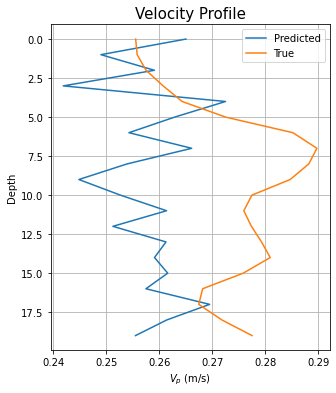

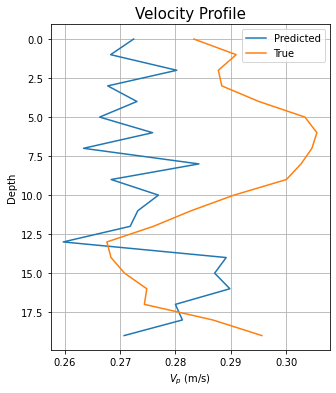

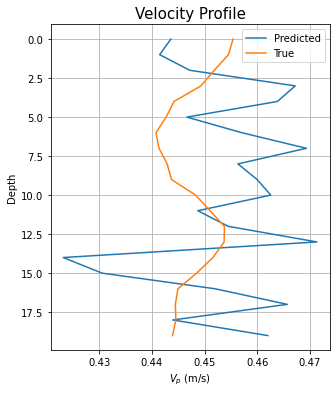

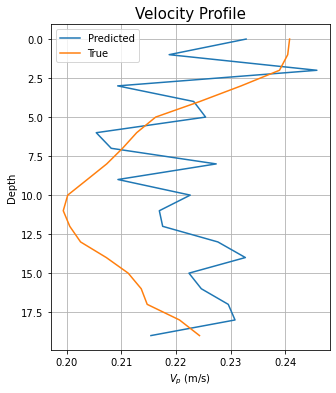

In [96]:
idx = torch.randint(high=len(valid_data2), size=(4,))
inputs_embeds = valid_data2.data['input'][idx]
labels = valid_data2.data['label'][idx]
with torch.no_grad():
    sample_output = model2(inputs_embeds=inputs_embeds.to(device))

for y, z in zip(sample_output.logits.cpu(), labels):
    f, ax = plt.subplots(1, 1, figsize=(5, 6))
    ax.plot(y, np.arange(len(y)), label="Predicted")
    ax.plot(z, np.arange(len(z)), label="True")
#     ax.plot(z-s, np.arange(len(z)), '--k', label="Std")
#     ax.plot(z+s, np.arange(len(z)), '--k')
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
#     yticks2 = [0]+list(np.arange(0, 3800, 500))
#     ax.set_yticklabels(yticks2)
    ax.set_ylabel("Depth")
    ax.set_xlabel("$V_p$ (m/s)")
#     ax.set_ylabel("Depth (m)")
    ax.set_title("Velocity Profile", fontsize=15)